In [1]:
import pandas as pd
import numpy as np
import os
from workalendar.europe import Russia
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool, cv
import copy
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin
from sklearn.model_selection import KFold
import shap

shap.initjs() 
pd.set_option('display.max_columns', None)

In [2]:
PATH_SOURCE = '../data/source'
PATH_PROCESSED = '../data/processed'
RANDOM_STATE = 42

In [3]:
os.listdir(PATH_SOURCE)

['test.csv',
 'train.csv',
 '.~lock.Данные для Хакатона Кейс 3 To send.xlsx#',
 'views.csv',
 'Данные для Хакатона Кейс 3 To send.xlsx']

In [4]:
dic_month = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12,
}

df_view = pd.read_excel(f'{PATH_SOURCE}/Данные для Хакатона Кейс 3 To send.xlsx', sheet_name='TV Viewing', header=3)
df_view = df_view.rename({'Unnamed: 0': 'month'}, axis=1)
df_view['month'] = df_view['month'].map(dic_month)
mask = ~df_view[2023].isna()
lr = LinearRegression().fit(df_view.loc[mask, [2021, 2022]], df_view.loc[mask, 2023])
df_view['2023_pred'] = lr.predict(df_view[[2021, 2022]])

In [5]:
df_view

,month,2021,2022,2023,2023_pred
0,1,327.924500,327.759667,319.902000,317.878063
1,2,315.605500,329.407333,310.317167,309.769000
2,3,302.231333,316.343000,298.144667,297.358259
3,4,280.771333,296.078667,276.041667,277.613792
4,5,265.527167,282.549833,263.562000,263.798566
5,6,255.598000,260.931500,257.940000,251.690063
6,7,256.821333,256.654500,252.891167,251.496389
7,8,260.952667,259.474833,253.577500,255.034981
8,9,274.169333,277.913833,262.384000,268.642178
9,10,290.561000,291.953333,281.895167,283.374042


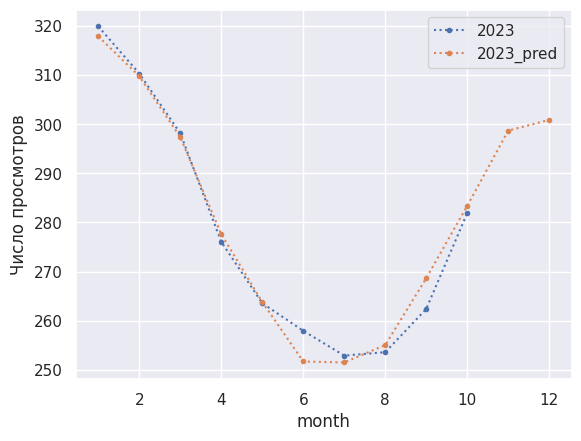

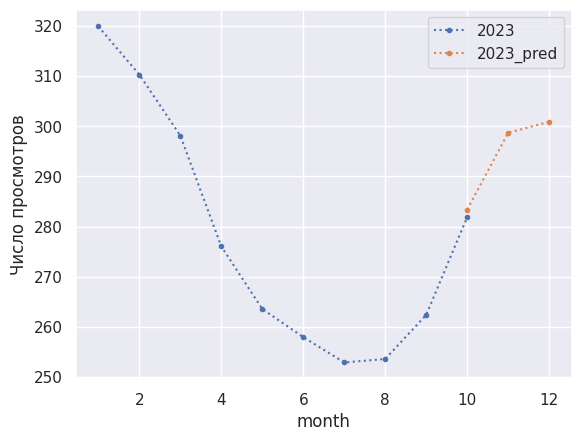

In [6]:
ax = df_view.set_index('month')[[2023, '2023_pred']].plot(style=':.')
ax.set_ylabel('Число просмотров')
plt.show()

df_view.loc[df_view['month'] < 10, '2023_pred'] = None
ax = df_view.set_index('month')[[2023, '2023_pred']].plot(style=':.')
ax.set_ylabel('Число просмотров')
plt.show()

In [7]:
df_view.loc[mask, 'tv_viewing'] = df_view.loc[mask, 2023]
df_view.loc[~mask, 'tv_viewing'] = df_view.loc[~mask, '2023_pred']
dic_tv_viewing = df_view.set_index('month')['tv_viewing'].to_dict()

In [8]:
dic_tv_viewing

{1: 319.902,
 2: 310.3171666666666,
 3: 298.1446666666667,
 4: 276.0416666666667,
 5: 263.562,
 6: 257.94000000000005,
 7: 252.89116666666666,
 8: 253.57750000000001,
 9: 262.38399999999996,
 10: 281.89516666666674,
 11: 298.6955111172877,
 12: 300.8857433041369}

In [9]:
otzovik_rating = {'Telekanal "Dobroe utro"':3.28,
               'Pro uyut':2.9,
               'Videli video?':2.87,
               'Povara na kolesakh':0,
               'Segodnya vecherom':4.4,
               'Podkast.Lab':0,
               'Dve zvezdy. Ottsy i deti':3.3,
               'Pole Chudes':3.3,
               'Igray, Garmon!':3.75,
               'Zdorovye':2.41,
               'AntiFeyk':0,
               'Zhit zdorovo':2.46,
               'Vremya pokazhet':2.12,
               'Bolshaya igra':3.2,
               'Muzhskoe/zhenskoe':2.7,
               'Vechernie novosti':2.14,
               'Chelovek i Zakon':3.11,
               'Poekhali!':0,
               'Tri akkorda':3,
               'Vremya':2.14,
               'Golos':3.6,
               'What? Where? When?':3.76,
               'Kukly naslednika Tutti':1.9,
               'Kto khochet stat millionerom?':3.1,
               'Davay pozhenimsya!':2.7,
               'Golos. Uzhe ne deti':4.67
       }

otzovik_recomemndation = {'Telekanal "Dobroe utro"':60,
               'Pro uyut':40,
               'Videli video?':45,
               'Povara na kolesakh':0,
               'Segodnya vecherom':94,
               'Podkast.Lab':0,
               'Dve zvezdy. Ottsy i deti':50,
               'Pole Chudes':53,
               'Igray, Garmon!':81,
               'Zdorovye':29,
               'AntiFeyk':0,
               'Zhit zdorovo':34,
               'Vremya pokazhet':27,
               'Bolshaya igra':53,
               'Muzhskoe/zhenskoe':44,
               'Vechernie novosti':30,
               'Chelovek i Zakon':54,
               'Poekhali!':0,
               'Tri akkorda':51,
               'Vremya':30,
               'Golos':66,
               'What? Where? When?':74,
               'Kukly naslednika Tutti':22,
               'Kto khochet stat millionerom?':55,
               'Davay pozhenimsya!':40,
               'Golos. Uzhe ne deti':87
       }

otzovik_cnt_otzyv = {'Telekanal "Dobroe utro"':127,
               'Pro uyut':60,
               'Videli video?':75,
               'Povara na kolesakh':0,
               'Segodnya vecherom':19,
               'Podkast.Lab':0,
               'Dve zvezdy. Ottsy i deti':16,
               'Pole Chudes':92,
               'Igray, Garmon!':16,
               'Zdorovye':93,
               'AntiFeyk':0,
               'Zhit zdorovo':254,
               'Vremya pokazhet':763,
               'Bolshaya igra':26,
               'Muzhskoe/zhenskoe':480,
               'Vechernie novosti':97,
               'Chelovek i Zakon':44,
               'Poekhali!':0,
               'Tri akkorda':87,
               'Vremya':97,
               'Golos':341,
               'What? Where? When?':105,
               'Kukly naslednika Tutti':54,
               'Kto khochet stat millionerom?':89,
               'Davay pozhenimsya!':318,
               'Golos. Uzhe ne deti':9
       }



program_rus = {'Telekanal "Dobroe utro"':'Телеканал "Доброе утро"',
               'Pro uyut':'ПроУют',
               'Videli video?':'Видели видео?',
               'Povara na kolesakh':'Повара на колесах',
               'Segodnya vecherom':'Сегодня вечером',
               'Podkast.Lab':'Подкаст.Лаб',
               'Dve zvezdy. Ottsy i deti':'Две звезды. Отцы и дети',
               'Pole Chudes':'Поле чудес',
               'Igray, Garmon!':'Играй, гармонь любимая!',
               'Zdorovye':'Здоровье',
               'AntiFeyk':'АнтиФейк',
               'Zhit zdorovo':'Жить здорово!',
               'Vremya pokazhet':'Время покажет',
               'Bolshaya igra':'Большая игра',
               'Muzhskoe/zhenskoe':'Мужское / Женское',
               'Vechernie novosti':'Новости',
               'Chelovek i Zakon':'Человек и закон',
               'Poekhali!':'Поехали!',
               'Tri akkorda':'Три аккорда',
               'Vremya':'Время',
               'Golos':'Голос',
               'What? Where? When?':'Что? Где? Когда?',
               'Kukly naslednika Tutti':'Куклы наследника Тутти',
               'Kto khochet stat millionerom?':'Кто хочет стать миллионером?',
               'Davay pozhenimsya!':'Давай поженимся!',
               'Golos. Uzhe ne deti':'Голос. Уже не дети'
       }

program_first_dt = {'Telekanal "Dobroe utro"':'1987-07-13',
               'Pro uyut':'2022-10-01',
               'Videli video?':'2018-07-16',
               'Povara na kolesakh':'2022-12-25',
               'Segodnya vecherom':'2015-08-17',
               'Podkast.Lab':'2023-01-02',
               'Dve zvezdy. Ottsy i deti':'2006-10-22',
               'Pole Chudes':'1990-10-25',
               'Igray, Garmon!':'1986-02-07',
               'Zdorovye':'1960-02-23',
               'AntiFeyk':'2022-03-09',
               'Zhit zdorovo':'2010-08-16',
               'Vremya pokazhet':'2014-09-15',
               'Bolshaya igra':'2018-09-03',
               'Muzhskoe/zhenskoe':'2014-09-29',
               'Vechernie novosti':'1985-02-10',
               'Chelovek i Zakon':'1970-03-10',
               'Poekhali!':'2022-08-13',
               'Tri akkorda':'2014-09-21',
               'Vremya':'1968-01-01',
               'Golos':'2012-10-05',
               'What? Where? When?':'1975-09-04',
               'Kukly naslednika Tutti':'2023-03-27',
               'Kto khochet stat millionerom?':'1999-10-01',
               'Davay pozhenimsya!':'2008-07-28',
               'Golos. Uzhe ne deti':'2023-09-01'
       }

dtype = {
    'Break flight start': str,
    'Break flight end': str, 
    'Programme flight start': str,
    'Programme flight end': str,
}
time_clms = ['break_flight_start', 'break_flight_end', 'programme_flight_start', 'programme_flight_end']

train = pd.read_excel(f'{PATH_SOURCE}/Данные для Хакатона Кейс 3 To send.xlsx', sheet_name='train', dtype=dtype)
test = pd.read_excel(f'{PATH_SOURCE}/Данные для Хакатона Кейс 3 To send.xlsx', sheet_name='test data', dtype=dtype)
test = test.rename({'TVR Index Forecast': 'TVR Index'}, axis=1)
train['split'] = 'train'
test['split'] = 'test'
df = pd.concat([train, test], sort=False, ignore_index=True)
df.columns = [col.replace(' ', '_').lower() for col in df.columns]
df = df.rename({'tvr_index': 'target'}, axis=1)

# программы на русском
df['program_rus'] = df['programme'].map(program_rus)

# разбираемся с временем начала/окончания
for col in time_clms:
    mask = df[col].str.contains('1900-01-01')
    df[col] = df[col].str.replace('1900-01-01 ', '')
    df[f'{col}_hour'] = df[col].str.split(':').str[0].astype(int)
    df.loc[mask, f'{col}_hour'] = df.loc[mask, f'{col}_hour'] + 24
    df.loc[mask, col] = (df.loc[mask, 'date'] + pd.DateOffset(days=1)).astype(str) + ' ' + df.loc[mask, col]
    df.loc[~mask, col] = df.loc[~mask, 'date'].astype(str) + ' ' + df.loc[~mask, col]
    df[col] = pd.to_datetime(df[col])
    
    # calculate unix datetime
    df[f'{col}_unix'] = (df[col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    
# рейтинги с отзовика
df['otzovik_rating'] = df['programme'].map(otzovik_rating)
df['otzovik_recomemndation'] = df['programme'].map(otzovik_recomemndation)
df['otzovik_cnt_otzyv'] = df['programme'].map(otzovik_cnt_otzyv)
df['program_first_dt'] = pd.to_datetime(df['programme'].map(program_first_dt))

# df = df.merge(mean_by_prog_day, on='break_flight_id')

In [10]:
df.to_pickle(f'{PATH_PROCESSED}/df.pickle')

In [11]:
df['break_distribution'].value_counts()

Network    28899
Orbital     5111
Local          1
Name: break_distribution, dtype: int64

In [12]:
df.shape

(34011, 26)

In [13]:
df.columns

Index(['target', 'date', 'break_flight_id', 'break_flight_start',
       'break_flight_end', 'break_content', 'break_distribution', 'programme',
       'programme_flight_start', 'programme_flight_end', 'programme_category',
       'programme_genre', 'split', 'program_rus', 'break_flight_start_hour',
       'break_flight_start_unix', 'break_flight_end_hour',
       'break_flight_end_unix', 'programme_flight_start_hour',
       'programme_flight_start_unix', 'programme_flight_end_hour',
       'programme_flight_end_unix', 'otzovik_rating', 'otzovik_recomemndation',
       'otzovik_cnt_otzyv', 'program_first_dt'],
      dtype='object')

In [14]:
# возраст программы
df['programme_age'] = (df['date'] - df['program_first_dt']).dt.days

In [15]:
# праздники
cal = Russia()
dic_holidays = {pd.Timestamp(dt): holiday_name for dt, holiday_name in cal.holidays(2023)}

df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.day_of_week
df['day_name'] = df['date'].dt.day_name()
df['weekofyear'] = df['date'].dt.weekofyear
df["quarter"] = df['date'].dt.quarter
df["year_half"] = (df['date'].dt.quarter + 1) // 2
df['days_in_month'] = df['date'].dt.days_in_month
df['is_leap_year'] = df['date'].dt.is_leap_year
df['is_month_end'] = df['date'].dt.is_month_end
df['is_month_start'] = df['date'].dt.is_month_start
df['is_quarter_end'] = df['date'].dt.is_quarter_end
df['is_quarter_start'] = df['date'].dt.is_quarter_start
df['is_working_day'] = df['date'].apply(cal.is_working_day)
df['holiday_name'] = df['date'].map(dic_holidays.get).fillna('na')
df['is_holiday'] = (df['holiday_name'] != 'na').astype(int)

# прайм тайм
df['is_prime_time_working'] = (df['is_working_day'] & (20 <= df['break_flight_start_hour']) & (df['break_flight_start_hour'] <= 22)).astype(int)
df['is_prime_time_weekend'] = (~df['is_working_day'] & (17 <= df['break_flight_start_hour']) & (df['break_flight_start_hour'] <= 23))
df['is_prime_time'] = ((df['is_prime_time_working'] == 1) | (df['is_prime_time_weekend'] == 1)).astype(int)

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.


In [16]:
# просмотры
df['tv_viewing'] = df['month'].map(dic_tv_viewing)

In [17]:
mask_train = df['split'] == 'train'
mask_test = df['split'] == 'test'

In [18]:
print(set(df.loc[mask_train, 'program_rus']) - set(df.loc[mask_test, 'program_rus']))
print(set(df.loc[mask_test, 'program_rus']) - set(df.loc[mask_train, 'program_rus']))

{'Голос. Уже не дети', 'Голос', 'Три аккорда', 'Две звезды. Отцы и дети'}
set()


In [19]:
df.groupby(['break_distribution', 'split']).size().unstack('split')

# выделяем часть на валидацию
rank_day = df.groupby('month')['day'].rank(method='dense', ascending=False)
# mask_val = (rank_day <= 7) & (df['split'] != 'test')
mask_val = (df['month'] == 10) & (df['split'] != 'test')

df.loc[mask_val, 'split'] = 'val'

q1 = df['break_distribution'] == 'Local'
q2 = df['target'] == 0
q3 = df['program_rus'].isin(['Голос. Уже не дети', 'Три аккорда', 'Голос', 'Две звезды. Отцы и дети'])
q4 = df['split'] == 'train'
q5 = df['split'] == 'val'
q6 = df['split'] == 'test'

mask_bad = (q4 & (q1 | q3)) | (q5 & (q1 | q3)) | (q6 & q3)
df.loc[mask_bad, 'split'] = 'bad'

mask_train = df['split'] == 'train'
mask_val = df['split'] == 'val'
mask_test = df['split'] == 'test'

In [20]:
df.query('target == 0')['programme'].unique()

array(['Podkast.Lab'], dtype=object)

<AxesSubplot: >

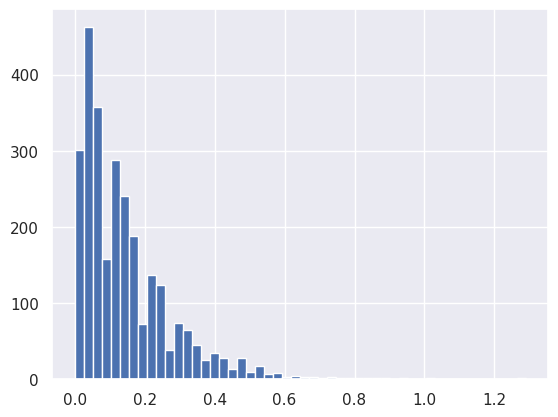

In [21]:
df.query('programme == "Podkast.Lab" and target == target')['target'].hist(bins=50)

In [22]:
df['split'].value_counts()

train    26723
test      3329
val       3151
bad        808
Name: split, dtype: int64

In [23]:
df.query('target == 0')['split'].value_counts()

train    88
val      22
Name: split, dtype: int64

In [24]:
# длительности блока и программы
df['break_duration'] = (df['break_flight_end'] - df['break_flight_start']).dt.seconds
df['programme_duration'] = (df['programme_flight_end'] - df['programme_flight_start']).dt.seconds

# через сколько времени от начала программы началась реклама
df['break_start_programme'] = (df['break_flight_start'] - df['programme_flight_start']).dt.seconds

# за сколько времени до окончания программы началась реклама
df['break_end_programme'] = (df['programme_flight_end'] - df['break_flight_start']).dt.seconds

# когда началась реклама относительно времени проведения программы
df['break_start_programme_rate'] = df['break_start_programme'] / df['programme_duration']

group = df.groupby('programme_flight_start')
# количество рекламных блоков в программе
df['break_cnt'] = group['break_flight_id'].transform('count')

# общая длительность рекламных блоков в программе 
df['break_duration_all'] = group['break_duration'].transform('sum')

# реальная длительность программы
df['programme_duration_real'] = df.eval('programme_duration - break_duration_all')

# отношение реальной длительности программы к длительности с рекламными блоками
df['programme_duration_real_rate'] = df.eval('programme_duration_real / programme_duration')

# средний интервал между рекламными блоками
df['break_interval'] = df.eval('(programme_duration - break_duration) / break_cnt')

In [25]:
# сколько времени прошло с окончания показа предыдущей рекламы
df = df.sort_values('break_flight_start', ascending=True).reset_index(drop=True)
df['seconds_from_last_break'] = (df['break_flight_start'] - df['break_flight_end'].shift(1)).dt.seconds
df.loc[0, 'seconds_from_last_break'] = 19584.0

In [26]:
# {
# break_content': 'эта переменная представляет содержание или тип рекламной паузы во время телепрограммы
# 2. `break_distribution': 'указывает стратегию распространения или распределения рекламных пауз в телепрограмме
# 3. `programme_category': 'эта переменная относится к категории или жанру телепрограммы
# 4. `programme_genre': 'представляет жанр или тип телепрограммы
# 5. `break_flight_start_hour': 'час, в который рекламная пауза начинает выходить в эфир во время полета (период трансляции)
# 6. `break_flight_end_hour': 'час, в который рекламная пауза заканчивается в эфире во время полета (период трансляции)
# 7. `programme_flight_start_hour': 'час, в который телепрограмма начинает выходить в эфир во время полета (период вещания)
# 8. `programme_flight_end_hour': 'час, в который телепрограмма заканчивается в эфире во время полета (период вещания)
# 9. «day': 'указывает день месяца
# 10. `day_of_week': 'день недели, когда выходит в эфир телепрограмма или рекламная пауза
# 11. «quarter': 'квартал года, к которому относится телепрограмма или рекламная пауза
# 12. `year_half`	 представляет половину года (например, 1 для первого полугодия, 2 для второго полугодия)
# 13. `is_working_day`	 двоичный индикатор (0 или 1), который показывает, является ли день рабочим или нет
# 14. `is_prime_time_working`	 двоичный индикатор (0 или 1), который показывает, транслируется ли телепрограмма или рекламная пауза в прайм-тайм в рабочий день
# 15. `break_duration`	 продолжительность рекламной паузы в секундах
# 16. `programme_duration`	 продолжительность телепрограммы в секундах
# 17. `break_start_programme`	 разница во времени между началом рекламной паузы и началом телепрограммы
# 18. `break_end_programme`	 разница во времени между окончанием рекламной паузы и окончанием телепрограммы
# 19. `break_cnt`	 количество рекламных пауз в телепрограмме
# 20. `break_duration_all`	 общая продолжительность или продолжительность всех рекламных пауз в телепрограмме
# 2programme_duration_real`	реальная длительность программы
# 22. `programme_duration_real_rate`	отношение реальной длительности программы к длительности с рекламными блоками
# 23. `break_interval`	 Продолжительность времени между последовательными рекламными паузами в телепрограмме
# 24. `секунды_from_last_break`	 сколько времени прошло с окончания показа предыдущей рекламы (продолжительность времени с момента последней рекламной паузы в телепрограмме)
# 25. `programme_prev`	 предыдущая телепрограмма вышла в эфир перед текущей
# 26. `programme_genre_prev`	 Жанр или тип предыдущей телепрограммы
# 27. `programme_category_prev`	 категория предыдущей телепрограммы
# 28. `programme_genre_next`	 Жанр или тип следующей телепрограммы, запланированной после текущей
# 29. `programme_category_next`	 категория следующей телепрограммы, запланированной после текущей
# 30. `programme_num`	 номер или индекс, присвоенный телепрограмме
# 3break_num`	 номер или индекс, присвоенный рекламной паузе в телепрограмме
# 32. `break_content_podkastlab`	которая показывает, связана ли рекламная пауза с контентом «Подкастлаб»
# 33. `break_content_pole_chudes`	которая показывает, связана ли рекламная пауза с контентом "Pole Chudes"
# 34. `break_distribution_pole_chudes`	связано ли распространение рекламной паузы с контентом "Pole Chudes"
# 35. `programme_genre_podkastlab`	Жанр или тип телепрограммы, связанной с контентом «Подкастлаб»
# 36. `programme_category_podkastlab`	категория телепрограммы, связанной с контентом «Подкастлаб»
# 37. `programme_next_podkastlab`	двоичный индикатор (0 или 1), который показывает, связана ли следующая телепрограмма с контентом «Подкастлаб»
# 38. `target_programme`	переменная, представляющая телепрограмму
# 39. `target_break_content`	переменная, представляющая содержание или тип рекламной паузы
# 40. `target_break_distribution`	переменная, представляющая стратегию распределения или распределения рекламных пауз
# 4target_programme_genre`	переменная, представляющая жанр или тип телепрограммы
# 42. `target_programme_category`	переменная, представляющая категорию телепрограммы
# 43. `target_break_flight_start_hour`	переменная, представляющая час, в который рекламная пауза начинает выходить в эфир во время полета
# 44. `target_day_of_week`	переменная, представляющая день недели, когда выходит в эфир телепрограмма или рекламная пауза
# 45. `target_programme_prev`	переменная, представляющая предыдущую телепрограмму, вышедшую в эфир перед текущей
# 46. `target_programme_category_prev`	переменная, представляющая категорию предыдущей телепрограммы
# 47. `target_programme_next`	переменная, представляющая следующую телепрограмму, запланированную после текущей
# 48. `target_programme_genre_next`	переменная, представляющая жанр или тип следующей телепрограммы
# 49. `target_programme_category_next`	переменная, представляющая категорию следующей телепрограммы
# 50. `otzovik_rating`	 рейтинг или балл, присвоенный телепрограмме на основе отзывов пользователей или оценок на такой платформе, как «Отзовик»
# 5otzovik_recomemndation`	переменная, которая показывает, есть ли у телепрограммы рекомендации, основанные на отзывах пользователей от "Отзовика"
# 52. `otzovik_cnt_otzyv`	 количество  отзывов, полученных о телепрограмме на ресурсе "Отзовик"
# 53. `programme_age`	 возраст телепрограммы
# 54. `tv_viewing`	 показатель или мера телепросмотра или количества зрителей программы
# 55. `mean_by_prog_day`	 среднее значение, рассчитанное на основе определенного показателя или функции для каждой телепрограммы и комбинации дней
# }

In [27]:
# {
#     'break_content',
#  'break_distribution',
#  'programme_category',
#  'programme_genre',
#  'break_flight_start_hour',
#  'break_flight_end_hour',
#  'programme_flight_start_hour',
#  'programme_flight_end_hour',
#  'day',
#  'day_of_week',
#  'quarter',
#  'year_half',
#  'is_working_day',
#  'is_prime_time_working',
#  'break_duration',
#  'programme_duration',
#  'break_start_programme',
#  'break_end_programme',
#  'break_cnt',
#  'break_duration_all',
#  'programme_duration_real',
#  'programme_duration_real_rate',
#  'break_interval',
#  'seconds_from_last_break': 'сколько времени прошло с окончания показа предыдущей рекламы',
#  'programme_prev',
#  'programme_genre_prev',
#  'programme_category_prev',
#  'programme_genre_next',
#  'programme_category_next',
#  'programme_num',
#  'break_num',
#  'break_content_podkastlab',
#  'break_content_pole_chudes',
#  'break_distribution_pole_chudes',
#  'programme_genre_podkastlab',
#  'programme_category_podkastlab',
#  'programme_next_podkastlab',
#  'target_programme',
#  'target_break_content',
#  'target_break_distribution',
#  'target_programme_genre',
#  'target_programme_category',
#  'target_break_flight_start_hour',
#  'target_day_of_week',
#  'target_programme_prev',
#  'target_programme_category_prev',
#  'target_programme_next',
#  'target_programme_genre_next',
#  'target_programme_category_next',
#  'otzovik_rating',
#  'otzovik_recomemndation',
#  'otzovik_cnt_otzyv',
#  'programme_age',
#  'tv_viewing',
#  'mean_by_prog_day'
# }

In [28]:
df.columns

Index(['target', 'date', 'break_flight_id', 'break_flight_start',
       'break_flight_end', 'break_content', 'break_distribution', 'programme',
       'programme_flight_start', 'programme_flight_end', 'programme_category',
       'programme_genre', 'split', 'program_rus', 'break_flight_start_hour',
       'break_flight_start_unix', 'break_flight_end_hour',
       'break_flight_end_unix', 'programme_flight_start_hour',
       'programme_flight_start_unix', 'programme_flight_end_hour',
       'programme_flight_end_unix', 'otzovik_rating', 'otzovik_recomemndation',
       'otzovik_cnt_otzyv', 'program_first_dt', 'programme_age', 'day',
       'month', 'day_of_week', 'day_name', 'weekofyear', 'quarter',
       'year_half', 'days_in_month', 'is_leap_year', 'is_month_end',
       'is_month_start', 'is_quarter_end', 'is_quarter_start',
       'is_working_day', 'holiday_name', 'is_holiday', 'is_prime_time_working',
       'is_prime_time_weekend', 'is_prime_time', 'tv_viewing',
       'break_d

In [29]:
# следующие и предыдущая программы
# уникальный идентификатор программы по порядку
df['programme_id'] = df['programme_flight_start'].rank(method='dense').astype(int)

ttt = df[['programme', 'programme_genre', 'programme_category']].drop_duplicates()
dic_genre = ttt.set_index('programme')['programme_genre'].to_dict()
dic_category = ttt.set_index('programme')['programme_category'].to_dict()

ttt = df[['programme_id', 'programme']] \
    .drop_duplicates() \
    .sort_values('programme_id') \
    .reset_index(drop=True)

ttt['programme_prev'] = ttt['programme'].shift(1).fillna('Podkast.Lab')
ttt['programme_genre_prev'] = ttt['programme_prev'].map(dic_genre)
ttt['programme_category_prev'] = ttt['programme_prev'].map(dic_category)

ttt['programme_next'] = ttt['programme'].shift(-1).fillna('Telekanal "Dobroe utro"')
ttt['programme_genre_next'] = ttt['programme_next'].map(dic_genre)
ttt['programme_category_next'] = ttt['programme_next'].map(dic_category)

ttt = ttt.drop('programme', axis=1)

df = df.merge(ttt, on='programme_id').drop('programme_id', axis=1)

In [30]:
ttt

,programme_id,programme_prev,programme_genre_prev,programme_category_prev,programme_next,programme_genre_next,programme_category_next
0,1,Podkast.Lab,Entertainment programs,Entertainment talk show,Pro uyut,Entertainment programs,Program on fashion and design
1,2,"Telekanal ""Dobroe utro""",Entertainment programs,Morning airplay,Videli video?,Entertainment programs,Comic program
2,3,Pro uyut,Entertainment programs,Program on fashion and design,Povara na kolesakh,Entertainment programs,"Program for women, Cookery show"
3,4,Videli video?,Entertainment programs,Comic program,Segodnya vecherom,Entertainment programs,Entertainment talk show
4,5,Povara na kolesakh,Entertainment programs,"Program for women, Cookery show",Podkast.Lab,Entertainment programs,Entertainment talk show
...,...,...,...,...,...,...,...
6696,6697,Podkast.Lab,Entertainment programs,Entertainment talk show,Podkast.Lab,Entertainment programs,Entertainment talk show
6697,6698,Podkast.Lab,Entertainment programs,Entertainment talk show,Podkast.Lab,Entertainment programs,Entertainment talk show
6698,6699,Podkast.Lab,Entertainment programs,Entertainment talk show,Podkast.Lab,Entertainment programs,Entertainment talk show
6699,6700,Podkast.Lab,Entertainment programs,Entertainment talk show,Podkast.Lab,Entertainment programs,Entertainment talk show


In [31]:
# номер программы в течение дня
df['programme_num'] = df \
    .groupby(['month', 'day'])['programme_flight_start'] \
    .rank(method='dense').astype(int)

# номер рекламы в течение программы
df['break_num'] = df \
    .groupby(['month', 'day', 'programme_flight_start'])['break_flight_start'] \
    .rank(method='dense').astype(int)

In [32]:
df.head()

,target,date,break_flight_id,break_flight_start,break_flight_end,break_content,break_distribution,programme,programme_flight_start,programme_flight_end,programme_category,programme_genre,split,program_rus,break_flight_start_hour,break_flight_start_unix,break_flight_end_hour,break_flight_end_unix,programme_flight_start_hour,programme_flight_start_unix,programme_flight_end_hour,programme_flight_end_unix,otzovik_rating,otzovik_recomemndation,otzovik_cnt_otzyv,program_first_dt,programme_age,day,month,day_of_week,day_name,weekofyear,quarter,year_half,days_in_month,is_leap_year,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_working_day,holiday_name,is_holiday,is_prime_time_working,is_prime_time_weekend,is_prime_time,tv_viewing,break_duration,programme_duration,break_start_programme,break_end_programme,break_start_programme_rate,break_cnt,break_duration_all,programme_duration_real,programme_duration_real_rate,break_interval,seconds_from_last_break,programme_prev,programme_genre_prev,programme_category_prev,programme_next,programme_genre_next,programme_category_next,programme_num,break_num
0,0.614693,2023-01-02,4870830561,2023-01-02 08:17:33,2023-01-02 08:21:40,Commercial,Network,"Telekanal ""Dobroe utro""",2023-01-02 08:00:13,2023-01-02 10:00:14,Morning airplay,Entertainment programs,train,"Телеканал ""Доброе утро""",8,1672647453,8,1672647700,8,1672646413,10,1672653614,3.28,60,127,1987-07-13,12957,2,1,0,Monday,1,1,1,31,False,False,False,False,False,False,Day After New Year,1,0,False,0,319.902,247,7201,1040,6161,0.144424,9,1681,5520,0.76656,772.666667,19584.0,Podkast.Lab,Entertainment programs,Entertainment talk show,Pro uyut,Entertainment programs,Program on fashion and design,1,1
1,0.869565,2023-01-02,4870830614,2023-01-02 08:34:45,2023-01-02 08:38:52,Commercial,Network,"Telekanal ""Dobroe utro""",2023-01-02 08:00:13,2023-01-02 10:00:14,Morning airplay,Entertainment programs,train,"Телеканал ""Доброе утро""",8,1672648485,8,1672648732,8,1672646413,10,1672653614,3.28,60,127,1987-07-13,12957,2,1,0,Monday,1,1,1,31,False,False,False,False,False,False,Day After New Year,1,0,False,0,319.902,247,7201,2072,5129,0.287738,9,1681,5520,0.76656,772.666667,785.0,Podkast.Lab,Entertainment programs,Entertainment talk show,Pro uyut,Entertainment programs,Program on fashion and design,1,2
2,0.989505,2023-01-02,4870830629,2023-01-02 08:52:19,2023-01-02 08:56:23,Commercial,Network,"Telekanal ""Dobroe utro""",2023-01-02 08:00:13,2023-01-02 10:00:14,Morning airplay,Entertainment programs,train,"Телеканал ""Доброе утро""",8,1672649539,8,1672649783,8,1672646413,10,1672653614,3.28,60,127,1987-07-13,12957,2,1,0,Monday,1,1,1,31,False,False,False,False,False,False,Day After New Year,1,0,False,0,319.902,244,7201,3126,4075,0.434106,9,1681,5520,0.76656,773.000000,807.0,Podkast.Lab,Entertainment programs,Entertainment talk show,Pro uyut,Entertainment programs,Program on fashion and design,1,3
3,0.884558,2023-01-02,4870830684,2023-01-02 08:56:31,2023-01-02 08:57:28,Announcement,Network,"Telekanal ""Dobroe utro""",2023-01-02 08:00:13,2023-01-02 10:00:14,Morning airplay,Entertainment programs,train,"Телеканал ""Доброе утро""",8,1672649791,8,1672649848,8,1672646413,10,1672653614,3.28,60,127,1987-07-13,12957,2,1,0,Monday,1,1,1,31,False,False,False,False,False,False,Day After New Year,1,0,False,0,319.902,57,7201,3378,3823,0.469102,9,1681,5520,0.76656,793.777778,8.0,Podkast.Lab,Entertainment programs,Entertainment talk show,Pro uyut,Entertainment programs,Program on fashion and design,1,4
4,0.839580,2023-01-02,4870830685,2023-01-02 09:12:04,2023-01-02 09:16:13,Commercial,Network,"Telekanal ""Dobroe utro""",2023-01-02 08:00:13,2023-01-02 10:00:14,Morning airplay,Entertainment programs,train,"Телеканал ""Доброе утро""",9,1672650724,9,1672650973,8,1672646413,10,1672653614,3.28,60,127,1987-07-13,12957,2,1,0,Monday,1,1,1,31,False,False,False,False,False,False,Day After New Year,1,0,False,0,319.902,249,7201,4311,2890,0.598667,9,1681,5520,0.76656,772.444444,876.0

In [33]:
# категориальные фичи
def target_encoding(df, mask, group_clms):
    feature = 'target_'+'_'.join(group_clms)
    if feature in df.columns:
        df = df.drop(feature, axis=1)
    
    group = df[mask].groupby(group_clms)
    target_sum = group['target'].transform('sum') - df[mask]['target']
    cnt = group['target'].transform('count') - 1
    target = pd.concat([df[mask_train][group_clms], (target_sum / cnt).to_frame(feature)], axis=1)
    target = target.groupby(group_clms, as_index=False).mean()
    # if 'month' in group_clms:
    #     target_month_1 = target.query('month == 1').copy()
    #     target['month'] += 1
    #     target = pd.concat([target, target_month_1], sort=False, ignore_index=True)
        
    df = df.merge(target, on=group_clms, how='left')
    
    # # заполняем пропуски
    # group_clms = [col for col in group_clms if col != 'month']
    # mask = df[feature].isna()
    # df.loc[mask, feature] = df.groupby(group_clms)[feature].transform('mean')
    return df

list_group_clms = [
    ['programme'],
    ['break_content'],
    ['break_distribution'],
    ['programme_genre'],
    ['programme_category'],
    ['break_flight_start_hour'],
    ['day_of_week'],
    ['programme_prev'],
    ['programme_genre_prev'],
    ['programme_category_prev'],
    ['programme_next'],
    ['programme_genre_next'],
    ['programme_category_next'],
]

for group_clms in list_group_clms:
    df = target_encoding(df, mask_train, group_clms)

In [34]:
cat_features = [
    'programme',
    'break_content',
    'break_distribution',
    'programme_genre',
    'programme_category',
    'programme_prev',
    'programme_next',

]

df_cat_features = []
for col in cat_features:
    ttt = pd.get_dummies(df['programme'].str.replace(' ', '_').str.lower().str.replace('"', '').str.replace('.', '').str.replace('?', ''))
    ttt.columns = [f'{col}_{col_new}' for col_new in ttt.columns]
    df_cat_features.append(ttt)
df_cat_features = pd.concat(df_cat_features, axis=1)
df = pd.concat([df, df_cat_features], axis=1)

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
The default value of regex will change from True to False in a fu

In [35]:
len(df_cat_features.columns)

182

In [36]:
print(*df_cat_features.columns, sep="','")

programme_antifeyk','programme_bolshaya_igra','programme_chelovek_i_zakon','programme_davay_pozhenimsya!','programme_dve_zvezdy_ottsy_i_deti','programme_golos','programme_golos_uzhe_ne_deti','programme_igray,_garmon!','programme_kto_khochet_stat_millionerom','programme_kukly_naslednika_tutti','programme_muzhskoe/zhenskoe','programme_podkastlab','programme_poekhali!','programme_pole_chudes','programme_povara_na_kolesakh','programme_pro_uyut','programme_segodnya_vecherom','programme_telekanal_dobroe_utro','programme_tri_akkorda','programme_vechernie_novosti','programme_videli_video','programme_vremya','programme_vremya_pokazhet','programme_what_where_when','programme_zdorovye','programme_zhit_zdorovo','break_content_antifeyk','break_content_bolshaya_igra','break_content_chelovek_i_zakon','break_content_davay_pozhenimsya!','break_content_dve_zvezdy_ottsy_i_deti','break_content_golos','break_content_golos_uzhe_ne_deti','break_content_igray,_garmon!','break_content_kto_khochet_stat_millione

In [37]:
df.columns

Index(['target', 'date', 'break_flight_id', 'break_flight_start',
       'break_flight_end', 'break_content', 'break_distribution', 'programme',
       'programme_flight_start', 'programme_flight_end',
       ...
       'programme_next_segodnya_vecherom',
       'programme_next_telekanal_dobroe_utro', 'programme_next_tri_akkorda',
       'programme_next_vechernie_novosti', 'programme_next_videli_video',
       'programme_next_vremya', 'programme_next_vremya_pokazhet',
       'programme_next_what_where_when', 'programme_next_zdorovye',
       'programme_next_zhit_zdorovo'],
      dtype='object', length=261)

In [43]:
df.columns

Index(['target', 'date', 'break_flight_id', 'break_flight_start',
       'break_flight_end', 'break_content', 'break_distribution', 'programme',
       'programme_flight_start', 'programme_flight_end',
       ...
       'programme_next_segodnya_vecherom',
       'programme_next_telekanal_dobroe_utro', 'programme_next_tri_akkorda',
       'programme_next_vechernie_novosti', 'programme_next_videli_video',
       'programme_next_vremya', 'programme_next_vremya_pokazhet',
       'programme_next_what_where_when', 'programme_next_zdorovye',
       'programme_next_zhit_zdorovo'],
      dtype='object', length=261)

In [162]:
df['month'].max()

11

In [280]:


# group = ttt.groupby('programme')
# for col in clms:
#     ttt[col] = group[col].shift(32)
# ttt = ttt.dropna()

# for col in clms:
#     for i in [7, 14, 21]:
#         ttt[f'{col}_rolling_{i}'] = ttt \
#             .groupby('programme')[col] \
#             .rolling(i) \
#             .mean() \
#             .reset_index(0,drop=True)
# # ttt = ttt.dropna()

In [233]:
# ttt['date_max'] = ttt['date'] - pd.DateOffset(days=31)

In [239]:
from prophet import Prophet
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 

In [343]:
df.query('month == 10')['target'].isna().sum()

0

In [569]:
ttt = df[['date', 'month', 'day', 'programme', 'target']].copy()
# ttt.loc[ttt['month'] == 10, 'target'] = None
ttt = ttt \
    .sort_values('day') \
    .groupby(['date', 'month', 'day', 'programme'], as_index=False)['target'] \
    .mean() \
    .dropna()

clms = ['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'yhat']
forecast = []
for programme, subset in ttt.groupby('programme'):
    subset = subset[['date', 'target']]
    subset.columns = ['ds', 'y']
    for i in range(2, 13):
        mask = subset['ds'].dt.month < i
        if mask.sum() > 2:
            subset_ = subset[mask].copy()
            q1, q2 = subset_['y'].quantile([0.05, 0.95])
            subset_['y'] = subset_['y'].clip(q1, q2)
            ds = pd.DataFrame(pd.date_range(start=subset_['ds'].min(), end=subset_['ds'].max()), columns=['ds'])
            subset_ = ds.merge(subset_, on='ds', how='left')
            subset_['y'] = subset_['y'].interpolate(method='quadratic')

            m = Prophet(seasonality_mode='multiplicative', seasonality_prior_scale=1)
            m.fit(subset_.copy())
            future = m.make_future_dataframe(periods=62)
            forecast_ = m.predict(future)
            forecast_ = forecast_ \
                .loc[forecast_['ds'].dt.month >= i, clms] \
                .assign(programme=programme)
            forecast.append(forecast_)
forecast = pd.concat(forecast, sort=False, ignore_index=True)
forecast = forecast.drop_duplicates(subset=['ds', 'programme'], keep='last')
forecast = forecast.rename({'ds': 'date'}, axis=1)

03:40:37 - cmdstanpy - INFO - Chain [1] start processing
03:40:37 - cmdstanpy - INFO - Chain [1] done processing
03:40:38 - cmdstanpy - INFO - Chain [1] start processing
03:40:38 - cmdstanpy - INFO - Chain [1] done processing
03:40:38 - cmdstanpy - INFO - Chain [1] start processing
03:40:38 - cmdstanpy - INFO - Chain [1] done processing
03:40:38 - cmdstanpy - INFO - Chain [1] start processing
03:40:38 - cmdstanpy - INFO - Chain [1] done processing
03:40:38 - cmdstanpy - INFO - Chain [1] start processing
03:40:38 - cmdstanpy - INFO - Chain [1] done processing
03:40:38 - cmdstanpy - INFO - Chain [1] start processing
03:40:39 - cmdstanpy - INFO - Chain [1] done processing
03:40:39 - cmdstanpy - INFO - Chain [1] start processing
03:40:39 - cmdstanpy - INFO - Chain [1] done processing
03:40:39 - cmdstanpy - INFO - Chain [1] start processing
03:40:39 - cmdstanpy - INFO - Chain [1] done processing
03:40:39 - cmdstanpy - INFO - Chain [1] start processing
03:40:39 - cmdstanpy - INFO - Chain [1]

In [579]:
clms = [
    'trend',
    'yhat_lower',
    'yhat_upper',
    'trend_lower',
    'trend_upper',
    'yhat'
]
for col in clms:
    if col in df.columns:
        df = df.drop(col, axis=1)
df = df.merge(forecast, on=['date', 'programme'], how='left')
df = df.dropna(subset=clms)

In [580]:
df[[*clms, 'target', 'programme']].groupby('programme').corr()['target'].unstack('programme')

programme,AntiFeyk,Bolshaya igra,Chelovek i Zakon,Davay pozhenimsya!,Golos,"Igray, Garmon!",Kto khochet stat millionerom?,Kukly naslednika Tutti,Muzhskoe/zhenskoe,Podkast.Lab,Poekhali!,Pole Chudes,Povara na kolesakh,Pro uyut,Segodnya vecherom,"Telekanal ""Dobroe utro""",Tri akkorda,Vechernie novosti,Videli video?,Vremya,Vremya pokazhet,Zdorovye,Zhit zdorovo
trend,-0.139623,0.000452,0.247375,NaN,NaN,-0.085328,0.357953,-0.065724,0.083653,-0.036310,0.210829,0.278317,0.382713,0.212071,0.016972,0.152850,NaN,0.012709,0.032068,0.083385,-0.009608,-0.139575,-0.001387
yhat_lower,-0.175644,0.038588,0.260749,NaN,NaN,-0.075663,0.340915,-0.030359,0.154208,0.056839,0.249235,0.252242,0.327408,0.306879,0.040613,0.407578,NaN,0.302302,-0.002986,0.089346,0.150053,-0.078632,0.041850
yhat_upper,-0.185170,0.020205,0.227359,NaN,NaN,-0.067762,0.022631,-0.076713,0.188703,0.022211,0.111743,0.248431,0.381687,0.036124,-0.000750,0.392433,NaN,0.237520,0.038157,0.124534,0.151661,-0.213492,-0.019649
trend_lower,-0.139415,0.002321,0.261952,NaN,NaN,-0.089271,0.350179,-0.066769,0.082181,-0.036310,0.207322,0.224288,0.252715,0.278222,0.020399,0.151732,NaN,0.012880,0.032188,0.083373,-0.009165,-0.134423,-0.001297
trend_upper,-0.139837,-0.001223,0.232156,NaN,NaN,-0.081565,-0.019196,-0.064763,0.085203,-0.036312,0.214468,0.249674,0.386661,0.140517,0.006599,0.153886,NaN,0.012579,0.031938,0.083397,-0.010117,-0.144657,-0.001482
yhat,-0.179632,0.028554,0.244595,NaN,NaN,-0.081741,0.354933,-0.054398,0.173084,0.042767,0.201247,0.281879,0.381962,0.212140,0.020586,0.403922,NaN,0.269905,0.020934,0.112176,0.150387,-0.148866,0.009815
target,1.000000,1.000000,1.000000,NaN,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [573]:
df[[*clms, 'target', 'programme']].corr()['target']

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


trend          0.758482
yhat_lower     0.762317
yhat_upper     0.774221
trend_lower    0.757358
trend_upper    0.739619
yhat           0.783990
target         1.000000
Name: target, dtype: float64

In [588]:
subset

,ds,y
1634,2023-10-02,0.794603
1644,2023-10-03,0.836854
1654,2023-10-04,0.592885
1664,2023-10-05,0.822714
1673,2023-10-06,1.003248
1693,2023-10-09,1.002999
1703,2023-10-10,1.104448
1713,2023-10-11,0.764618
1723,2023-10-12,0.940780
1734,2023-10-13,0.812094


In [582]:
subset = ttt.query('programme == "Davay pozhenimsya!"')[['date', 'target']]
subset.columns = ['ds', 'y']
mask = subset['ds'].dt.month < 9

subset_ = subset[mask]
q1, q2 = subset_['y'].quantile([0.05, 0.95])
subset_['y'] = subset_['y'].clip(q1, q2)
ds = pd.DataFrame(pd.date_range(start=subset_['ds'].min(), end=subset_['ds'].max()), columns=['ds'])
subset_ = ds.merge(subset_, on='ds', how='left')
subset_['y'] = subset_['y'].interpolate(method='quadratic')
m = Prophet(seasonality_mode='multiplicative', seasonality_prior_scale=1)
m.fit(subset_.copy())
future = m.make_future_dataframe(periods=31)
forecast_ = m.predict(future)
m.plot(forecast_);

ValueError: Neither `start` nor `end` can be NaT

03:44:23 - cmdstanpy - INFO - Chain [1] start processing
03:44:23 - cmdstanpy - INFO - Chain [1] done processing


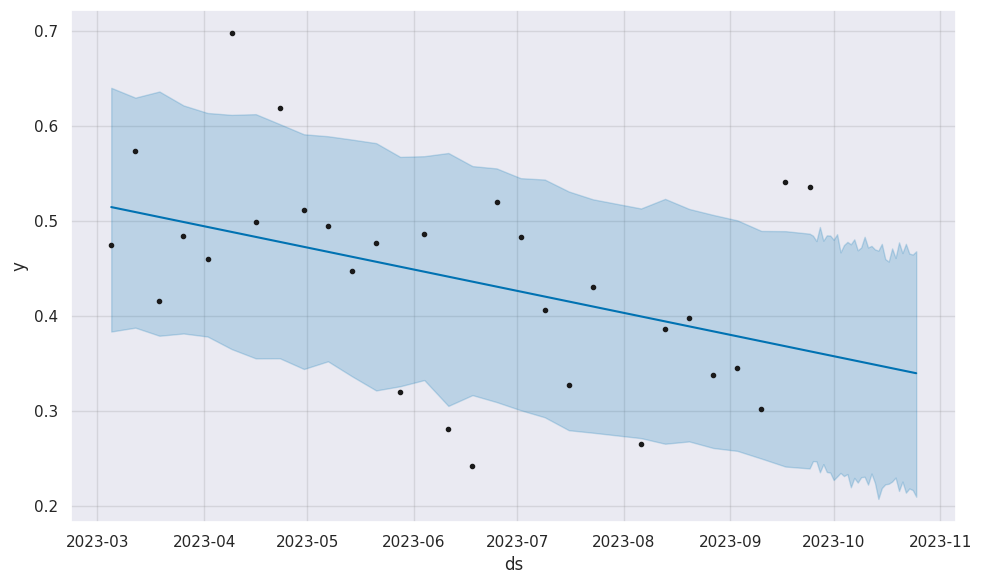

In [578]:
subset = ttt.query('programme == "Zdorovye"')[['date', 'target']]
subset.columns = ['ds', 'y']
mask = subset['ds'].dt.month < 10
m = Prophet(seasonality_mode='multiplicative', seasonality_prior_scale=1)
m.fit(subset[mask].copy())
future = m.make_future_dataframe(periods=31)
forecast_ = m.predict(future)
m.plot(forecast_);

In [441]:
forecast_

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-08-28,0.469511,0.710595,0.958384,0.469511,0.469511,0.370528,0.370528,0.370528,0.370528,0.370528,0.370528,0.0,0.0,0.0,0.840039
1,2023-08-29,0.472227,0.791652,1.055337,0.472227,0.472227,0.452262,0.452262,0.452262,0.452262,0.452262,0.452262,0.0,0.0,0.0,0.924489
2,2023-08-30,0.474942,0.783533,1.059647,0.474942,0.474942,0.435593,0.435593,0.435593,0.435593,0.435593,0.435593,0.0,0.0,0.0,0.910536
3,2023-08-31,0.477658,0.765897,1.045033,0.477658,0.477658,0.419573,0.419573,0.419573,0.419573,0.419573,0.419573,0.0,0.0,0.0,0.897231
4,2023-09-01,0.480373,0.536008,0.808047,0.480373,0.480373,0.200152,0.200152,0.200152,0.200152,0.200152,0.200152,0.0,0.0,0.0,0.680525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,2023-11-26,0.713907,-0.363529,-0.102353,0.713905,0.713909,-0.939054,-0.939054,-0.939054,-0.939054,-0.939054,-0.939054,0.0,0.0,0.0,-0.225147
83,2023-11-27,0.716623,0.956267,1.223065,0.716621,0.716624,0.370528,0.370528,0.370528,0.370528,0.370528,0.370528,0.0,0.0,0.0,1.087150
84,2023-11-28,0.719338,1.037616,1.310451,0.719336,0.719340,0.452262,0.452262,0.452262,0.452262,0.452262,0.452262,0.0,0.0,0.0,1.171600
85,2023-11-29,0.722054,1.025771,1.285960,0.722052,0.722056,0.435593,0.435593,0.435593,0.435593,0.435593,0.435593,0.0,0.0,0.0,1.157647


In [492]:
df.to_pickle(f'{PATH_PROCESSED}/df.pickle')

In [39]:
corr = df[mask_train].corr()['target']
index = corr.abs().sort_values(ascending=False).index
corr = corr[index].dropna()
corr.head(40)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


target                                  1.000000
target_programme                        0.781130
target_break_flight_start_hour          0.727968
target_programme_prev                   0.711554
target_programme_next                   0.567588
target_programme_category               0.551128
target_programme_category_prev          0.522962
programme_podkastlab                   -0.444747
programme_category_podkastlab          -0.444747
break_distribution_podkastlab          -0.444747
programme_genre_podkastlab             -0.444747
programme_prev_podkastlab              -0.444747
break_content_podkastlab               -0.444747
programme_next_podkastlab              -0.444747
programme_genre_pole_chudes             0.405310
break_content_pole_chudes               0.405310
programme_pole_chudes                   0.405310
break_distribution_pole_chudes          0.405310
programme_category_pole_chudes          0.405310
programme_prev_pole_chudes              0.405310
programme_next_pole_

In [40]:
corr = df[mask_val].corr()['target']
index = corr.abs().sort_values(ascending=False).index
corr = corr[index].dropna()
corr.head(40)

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


target                                  1.000000
target_programme                        0.843861
target_programme_prev                   0.812385
target_break_flight_start_hour          0.789161
target_programme_next                   0.627582
target_programme_category               0.552346
programme_next_podkastlab              -0.510190
programme_prev_podkastlab              -0.510190
programme_category_podkastlab          -0.510190
programme_genre_podkastlab             -0.510190
break_content_podkastlab               -0.510190
programme_podkastlab                   -0.510190
break_distribution_podkastlab          -0.510190
otzovik_rating                          0.476470
target_programme_category_next          0.456315
otzovik_recomemndation                  0.456202
target_programme_category_prev          0.418005
break_cnt                               0.417515
programme_pole_chudes                   0.411439
programme_next_pole_chudes              0.411439
break_content_pole_c